# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

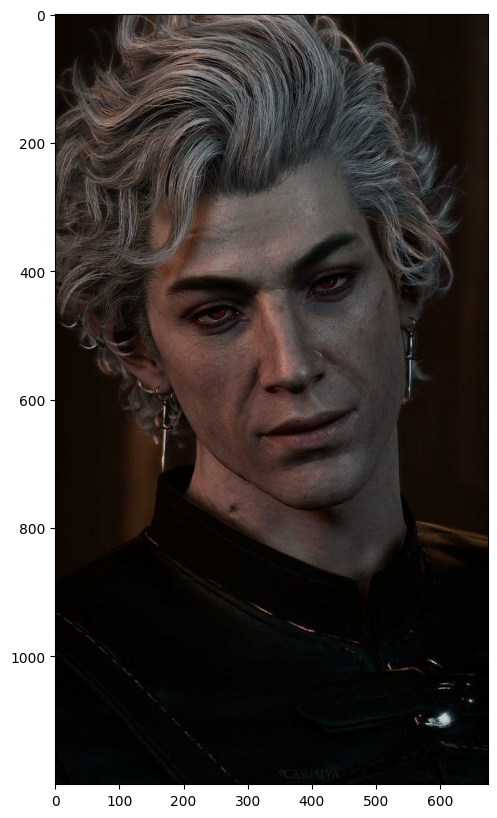

In [2]:
# Load image
img = cv2.imread('../data/husband.jpg')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [3]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [4]:
# Cast the image to float
img = np.float32(img)

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Apply quantization
def quantize(img, colors):
    rows, cols, _ = img.shape
    quantized = np.zeros_like(img)
    for r in range(rows):
        for c in range(cols):
            # Extract the original pixel value
            pixel = img[r, c, :]
            
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            new_pixel = colors[np.argmin(np.linalg.norm(colors - pixel, axis=1))] 
            # 1) calculate the distance from each channel of the pixel to each channel of the colors in pallette 
            # 2) given the distance in each channel, calculate the euclidean distance
            # 3) find the index of the minimum distance
            # 4) select the color from the pallette

            # Apply quantization
            quantized[r, c, :] = new_pixel
    return quantized
quantized = quantize(img, colors)


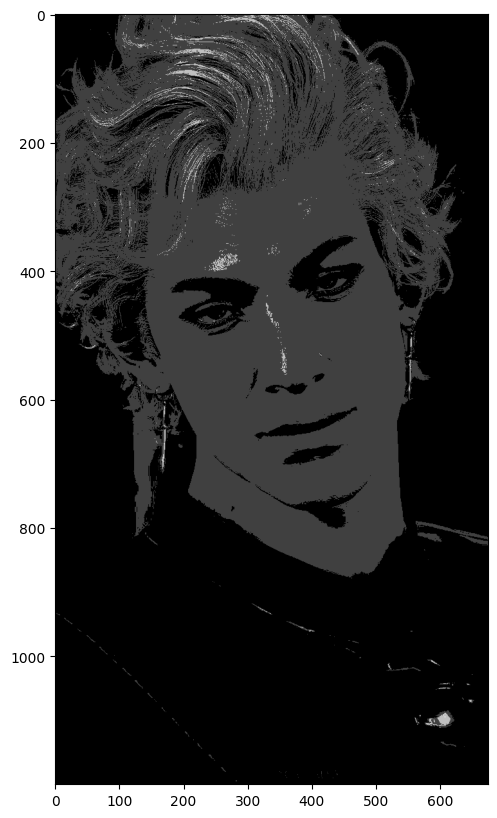

In [5]:
# Show quantized image (don't forget to cast back to uint8)
plt.imshow(np.uint8(quantized))

In [6]:
# Compute average quantization error 
# calculate MSE
avg_quant_error = np.mean(np.linalg.norm(img - quantized, axis=2))
# 1) calculate the distance (difference, eucledean distance) between the original pixel and the quantized pixel
# 2) calculate the mean of the distances in the image
print(avg_quant_error)

25.52083


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [7]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

def dithering_fs(img_tmp, colors):
    rows, cols, _ = img_tmp.shape
    dithering = np.zeros_like(img_tmp)
    for r in range(1, rows-1):
        for c in range(1, cols-1):
            # Extract the original pixel value
            pixel = img_tmp[r, c, :]
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            new_pixel = colors[np.argmin(np.linalg.norm(colors - pixel, axis=1))]        
            
            # Compute quantization error
            quant_error = pixel - new_pixel
            
            # Diffuse the quantization error accroding to the FS diffusion matrix
            # Note: You may need more than one line of code here
            #  pixels[x + 1][y    ] := pixels[x + 1][y    ] + quant_error × 7 / 16
            # pixels[x - 1][y + 1] := pixels[x - 1][y + 1] + quant_error × 3 / 16
            # pixels[x    ][y + 1] := pixels[x    ][y + 1] + quant_error × 5 / 16
            # pixels[x + 1][y + 1] := pixels[x + 1][y + 1] + quant_error × 1 / 16
            img_tmp[r + 1, c    , :] += quant_error * 7 / 16
            img_tmp[r - 1, c + 1, :] += quant_error * 3 / 16
            img_tmp[r    , c + 1, :] += quant_error * 5 / 16
            img_tmp[r + 1, c + 1, :] += quant_error * 1 / 16
            
            # Apply dithering
            dithering[r, c, :] = new_pixel
    return np.clip(dithering, 0, 255)
dithering = dithering_fs(img_tmp, colors)

(<Axes: >, <matplotlib.image.AxesImage at 0x1ea498ec3e0>)

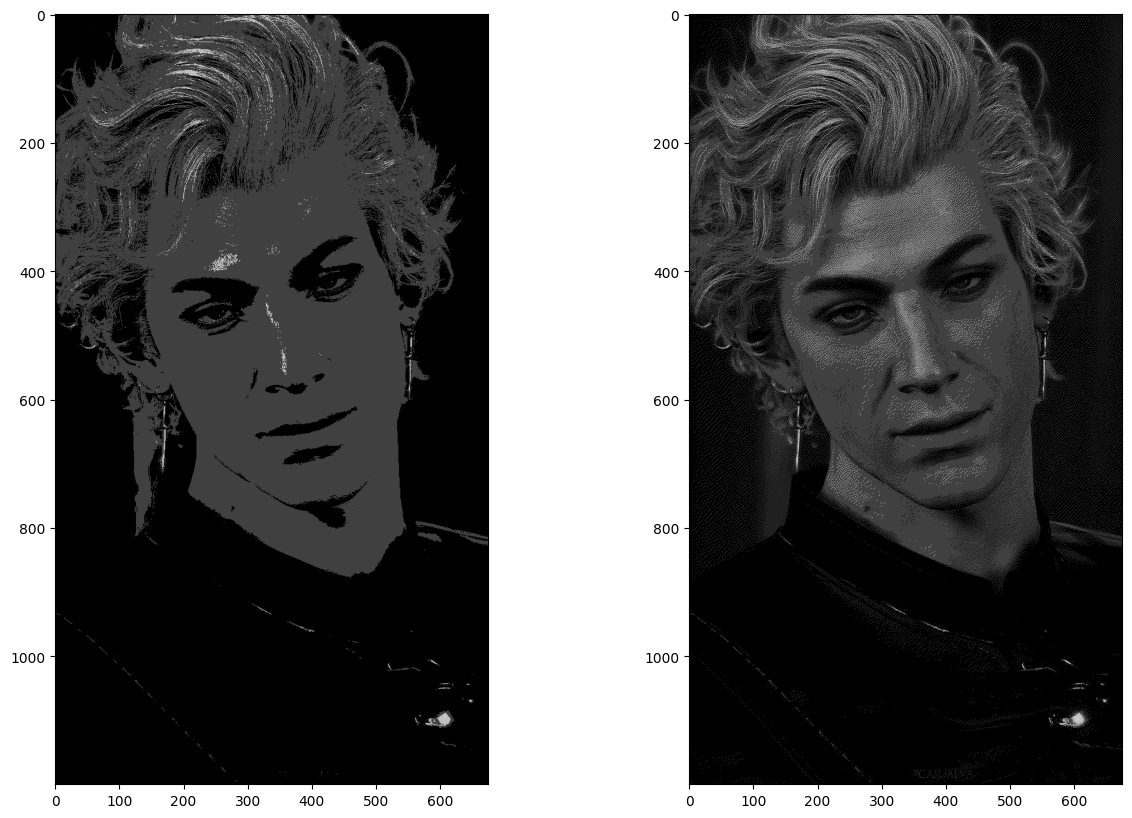

In [8]:
# Show quantized image (don't forget to cast back to uint8)
# prevent overflow
plt.subplot(121), plt.imshow(np.uint8(quantized))   # optimally quantized
plt.subplot(122), plt.imshow(np.uint8(dithering))   # dithering

In [11]:
# Compute average quantization error for dithered image
avg_dith_error = np.mean(np.linalg.norm(img - dithering, axis=2))
print(avg_dith_error)

107.65941


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
Dithered is looking well 
* Which image looks better to you?
In this case dithered looks better
* Can you repeat the same process using only two colours: black and white? Show me :-)
Below

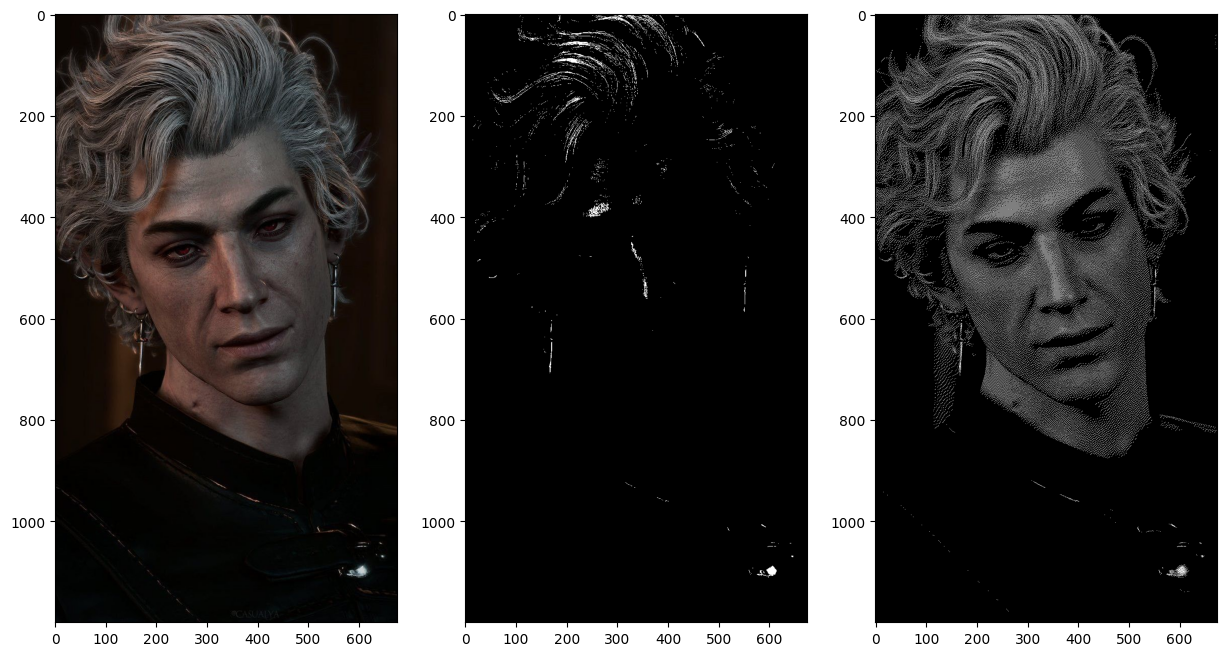

In [10]:
# only black and white
palette = np.array([[0, 0, 0],
                   [255, 255, 255]])

plt.subplot(131), plt.imshow(np.uint8(img))   
plt.subplot(132), plt.imshow(np.uint8(quantize(img, palette)))   
plt.subplot(133), plt.imshow(np.uint8(dithering_fs(img, palette)))   
plt.show()

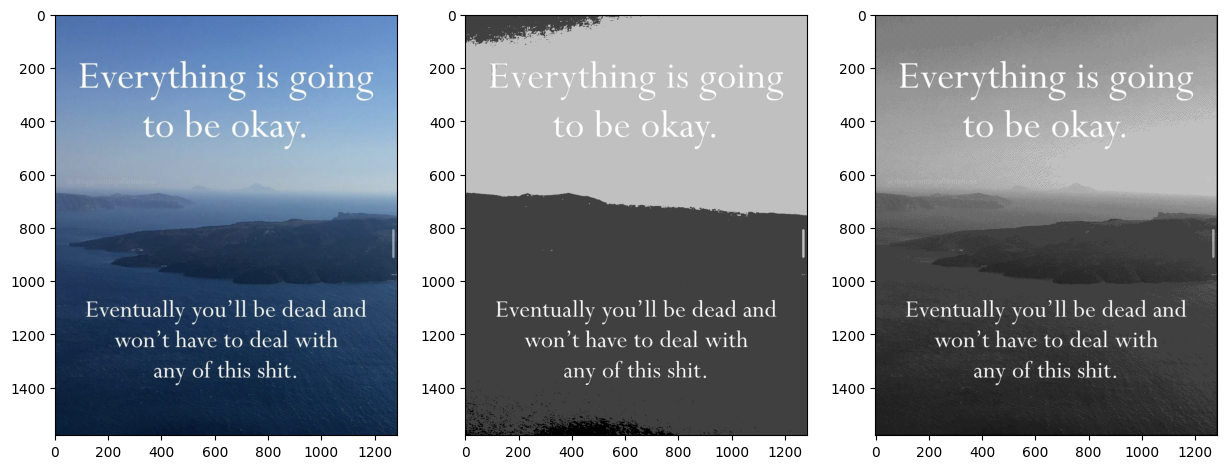

In [12]:
# Image with text
img2 = cv2.imread('../data/okay.jpeg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.subplot(131), plt.imshow(img2)   
plt.subplot(132), plt.imshow(np.uint8(quantize(np.float32(img2), colors)))   
plt.subplot(133), plt.imshow(np.uint8(dithering_fs(np.float32(img2), colors)))   
plt.show()

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 1)))
better_palette = kmeans.cluster_centers_

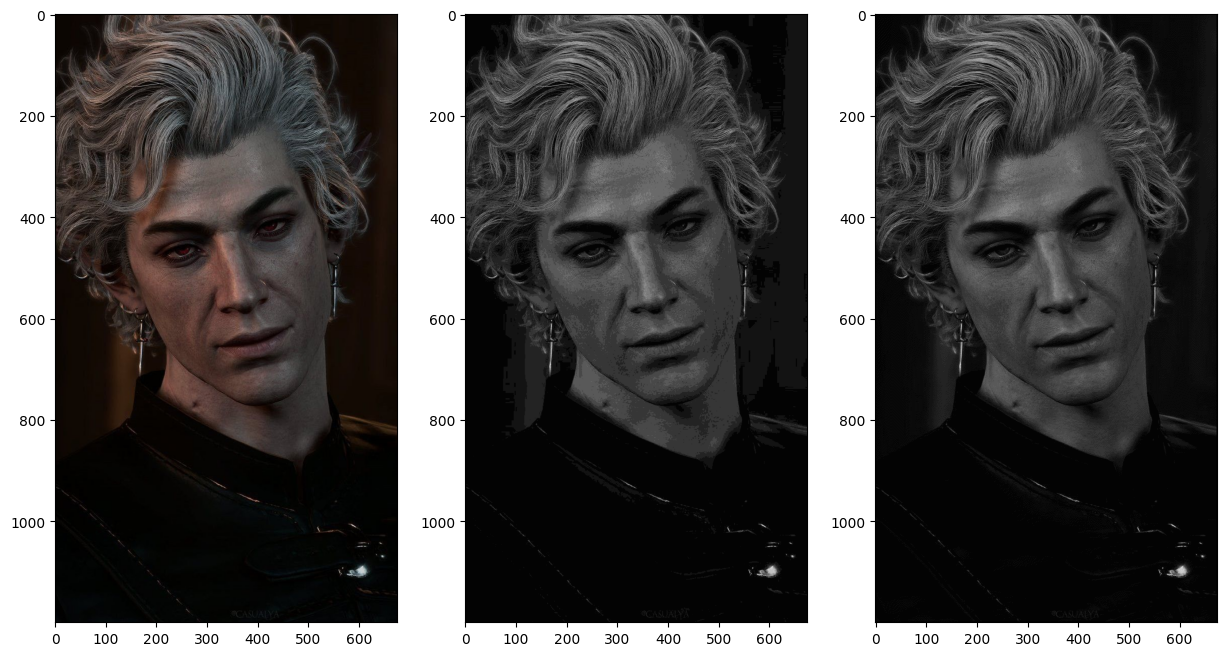

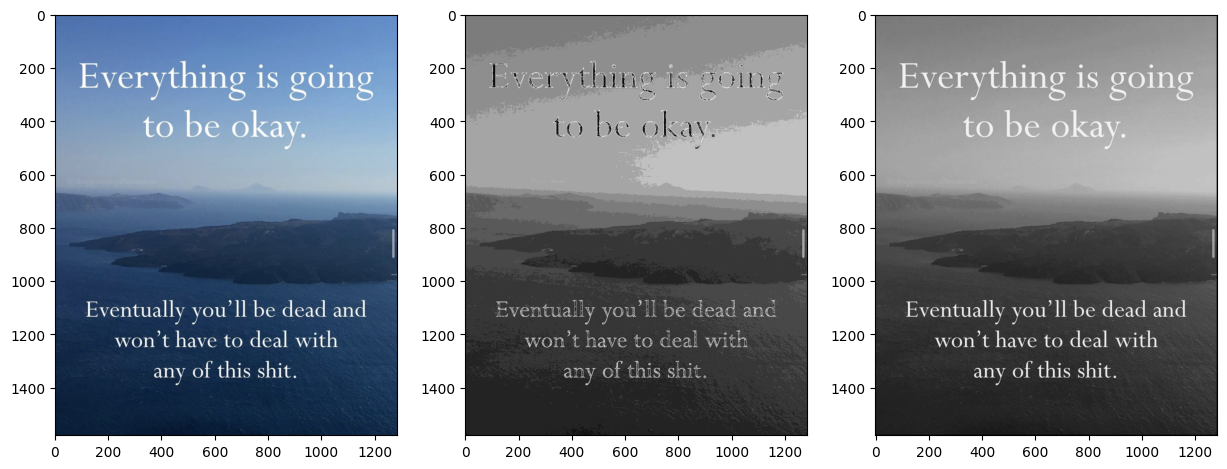

In [14]:
img = cv2.imread('../data/husband.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(131), plt.imshow(np.uint8(img))   
plt.subplot(132), plt.imshow(np.uint8(quantize(np.float32(img), better_palette)))   
plt.subplot(133), plt.imshow(np.uint8(dithering_fs(np.float32(img), better_palette)))   
plt.show()

plt.subplot(131), plt.imshow(img2)   
plt.subplot(132), plt.imshow(np.uint8(quantize(np.float32(img2), better_palette)))   
plt.subplot(133), plt.imshow(np.uint8(dithering_fs(np.float32(img2), better_palette))) 
plt.show()

Apply FS dithering the same way you did before.
* How does the result look like to you?
the result looks better than the previous one, dithering makes the image really better. 
* What happens if we use 32 colours?
Image looks better than the previous one, dithering makes an image really smoother
Implementation is below. 
* And what happens if we use 256 colours?
Image looks better and dithering is not needed actually (there are only 256 shades of gray). Dithering and Quantization gives the same result. Hovewer, dithering somehow changes colors to darker ones. 

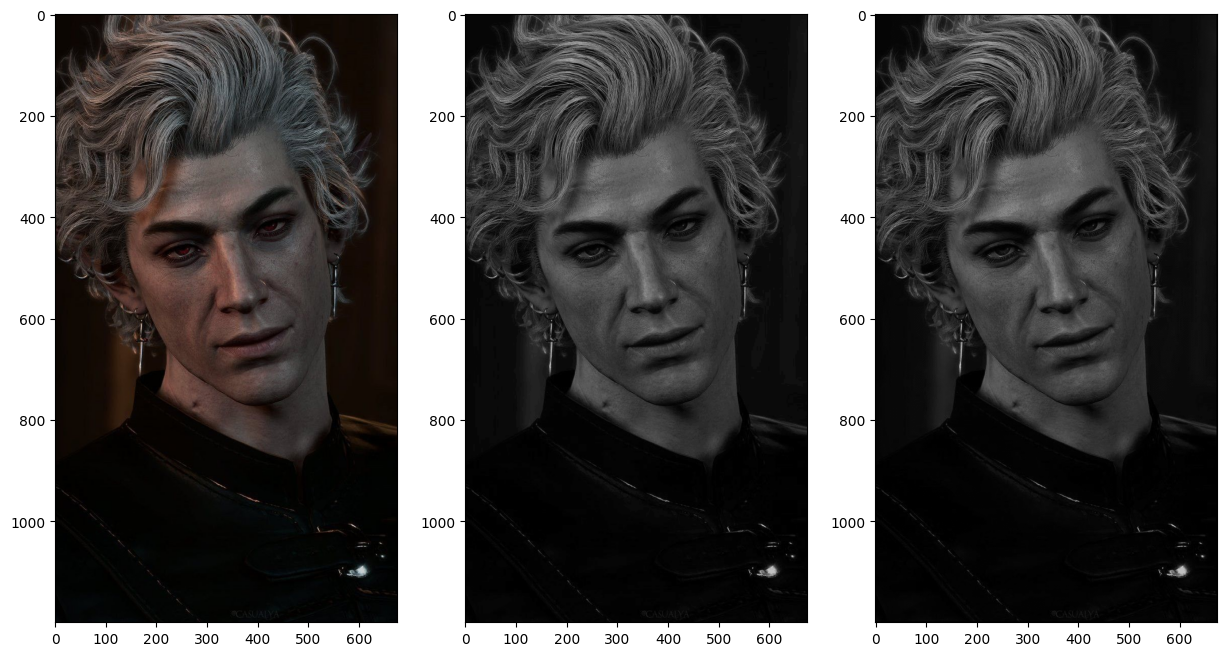

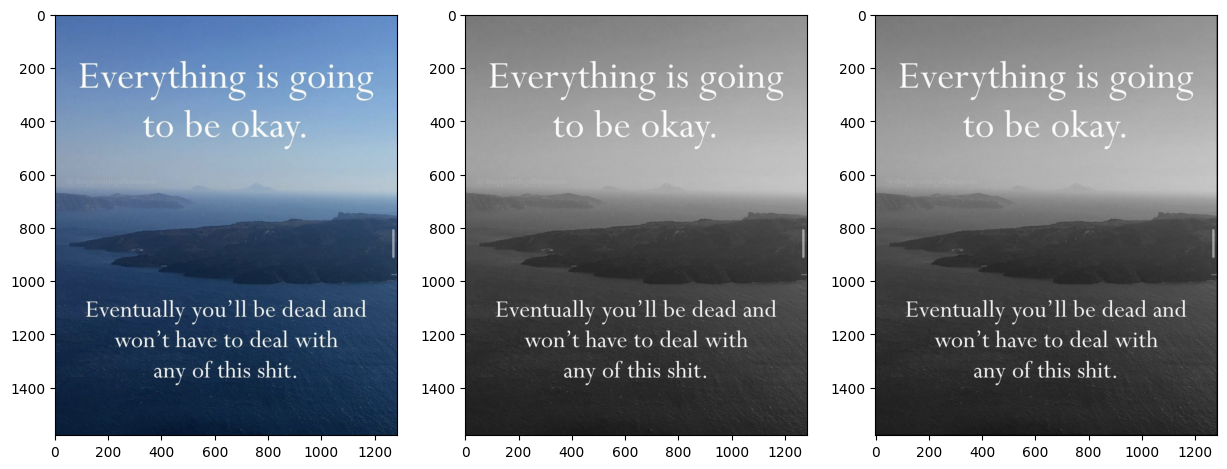

In [16]:
# 32 colors 
palette_32 = KMeans(n_clusters=32).fit(np.reshape(img, (-1, 1)))
better_palette_32 = palette_32.cluster_centers_
plt.subplot(131), plt.imshow(img)   
plt.subplot(132), plt.imshow(np.uint8(quantize(np.float32(img), better_palette_32)))   
plt.subplot(133), plt.imshow(np.uint8(dithering_fs(np.float32(img), better_palette_32)))   
plt.show()

# 256 colors
palette_256 = KMeans(n_clusters=256).fit(np.reshape(img2, (-1, 1)))
better_palette_256 = palette_256.cluster_centers_
plt.subplot(131), plt.imshow(img2)
plt.subplot(132), plt.imshow(np.uint8(quantize(np.float32(img2), better_palette_256)))
plt.subplot(133), plt.imshow(np.uint8(dithering_fs(np.float32(img2), better_palette_256)))
plt.show()